# Install packages

* Use sys.executable for pip commands ensuring the correct Python environment where the notebook is running is used

*  %conda is a magic command that allows to manage conda packages directly within the notebook environment ensuring that any packages installed are available to the current notebook kernel immediately

In [1]:
# Create conda environment using: conda create -n myenv python=3.X
# For conda environment removal use: conda env remove -n myenv


!{sys.executable} pip install -r C:\Users\fuji_\Desktop\PyGEO\Portfolio\ffsm_requirements.txt
%conda install -y GDAL

Retrieving notices: ...working... done
Channels:
 - defaults
 - conda-forge
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.



# Install custom aux_function.py packages

In [ ]:
!{sys.executable} pip install -r C:\Users\fuji_\Desktop\PyGEO\Geospatial-Ops\aux_functions_requirements.txt

# Install relevant geospatial packages using uv

* Around 400 packages installed and dependencies are automatically taken care of

* Install this inside a conda or virtual environment

In [5]:
!{sys.executable} -m pip install geospatial

Resolved 413 packages in 2.20s
Prepared 3 packages in 308ms
Uninstalled 4 packages in 828ms
Installed 313 packages in 16.37s
 + aenum==3.1.15
 + aiobotocore==2.15.1
 + aiohappyeyeballs==2.4.0
 + aiohttp==3.10.6
 + aioitertools==0.12.0
 + aiosignal==1.3.1
 + aniso8601==9.0.1
 + annotated-types==0.7.0
 + anyio==4.6.0
 + anywidget==0.9.13
 + apache-sedona==1.6.1
 + appdirs==1.4.4
 + argon2-cffi==23.1.0
 + argon2-cffi-bindings==21.2.0
 + arrow==1.3.0
 + asciitree==0.3.3
 + asgiref==3.8.1
 + async-lru==2.0.4
 + azure-core==1.31.0
 + azure-storage-blob==12.23.0
 + azure-storage-file-datalake==12.17.0
 + babel==2.16.0
 + bleach==6.1.0
 + blinker==1.8.2
 + bokeh==3.5.2
 + boto3==1.35.23
 + botocore==1.35.23
 + bounded-pool-executor==0.0.3
 + bqplot==0.12.43
 + branca==0.8.0
 + cachelib==0.9.0
 + cachetools==5.5.0
 + cenpy==1.0.1
 + cffi==1.17.1
 + chroma-py==0.1.0.dev1
 + cloudpathlib==0.19.0
 + cloudpickle==3.0.0
 + color-operations==0.1.5
 + colorcet==3.1.0
 + colorlog==6.8.2
 + colour==0.1.

# Import Packages

* And set current path directory

In [2]:
# Standard Library Imports

import sys
import os
import glob
import json
import time
import shutil
import pickle
from datetime import datetime
import subprocess

# External Library Imports
## Data Manipulation and Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox

## Geospatial Operations

import geopandas as gpd
from osgeo import gdal, ogr
from shapely.geometry import Point
from shapely import wkt
from pyproj import CRS
from shapely.geometry import shape

## Raster Operations

import rasterio
from rasterio import plot, merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.enums import Resampling
from rasterio.transform import Affine
from rasterio.features import shapes
from rasterio.mask import mask as rio_mask
from scipy.ndimage import distance_transform_edt
import rioxarray

## Parelization Operations

import dask.array as da

# Custom Module Imports

sys.path.append(r"C:\Users\fuji_\Desktop\pygeo\Geospatial-Ops")
import aux_functions as af
import importlib
importlib.reload(af)

# Set current user directory

user_dir = r"D:"

## Google Earth Engine

import ee
ee.Authenticate()
ee.Initialize()
import geemap
ee.Initialize()

## Data Visualization

import leafmap

# Conditioning Factors 

* Population Density
* LULC
* NDVI
* SSM
* Rainfall
* Windspeed
* Distance to Water
* Aspect
* Distance to Residential Zones
* Elevation
* Slope
* Distance to Roads

# **Population Density**

* https://hub.worldpop.org/geodata/listing?id=77

<Figure size 1000x600 with 0 Axes>

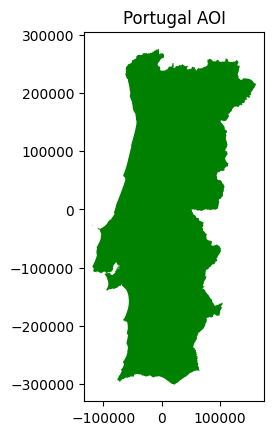

In [3]:
# First, we need a Portugal vector file, excluding the islands

# I downloaded the Boundaries from the official administrative map of Portugal (CAOP 2023) from Direção Geral do Território Dados Abertos (open data)

# Then i dissolved one of the layers that contained multipolygons of different boundaries and saved it as a geojson with EPSG:3763

portugal_path = r"C:\Users\fuji_\Desktop\Geospatial_Misc\Portugal_Boundaries\pt_dissolved_geojson_3763.geojson"

portugal_gdf = gpd.read_file(portugal_path)


# Plot the figure
plt.figure(figsize=(10, 6))
portugal_gdf.plot(marker='o', color='g', markersize=10)
plt.title('Portugal AOI')
plt.show()

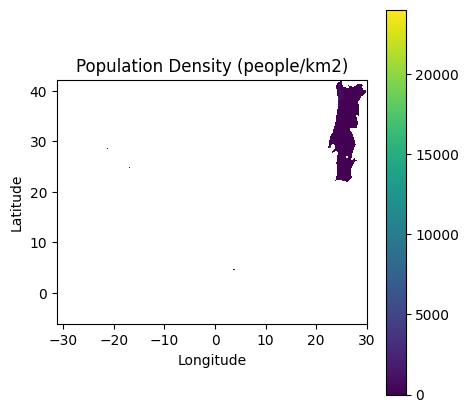

In [8]:
# Open the raster file and clip the raster with the vector layer above

pop_density_raster = r"C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\Densidade_Populacional\prt_pd_2020_1km.tif"

with rasterio.open(pop_density_raster) as src:
    image = src.read(1)  # Assuming land use/cover data is in the first band

    # Extract features (polygons for each unique value)
    mask = image != 0  # Optionally, create a mask to exclude certain values (e.g., 0 for nodata)
    results = (
        {'properties': {'land_cover': v}, 'geometry': s}
        for i, (s, v) in enumerate(shapes(image, mask=mask, transform=src.transform))

    )

    # Read the first band of the raster
    raster_data = src.read(1)
    
    # Get the No Data value from the raster metadata
    no_data_value = src.nodata

    # Mask the No Data values for visualization
    masked_data = np.ma.masked_where(raster_data == no_data_value, raster_data)
    
    # Plot the raster
    plt.figure(figsize=(5, 5))
    plt.imshow(masked_data, cmap='viridis', extent=src.bounds) # Change raster_data to masked_data
    
    # Set titles and labels
    plt.title("Population Density (people/km2)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label=None)
    
    plt.show()

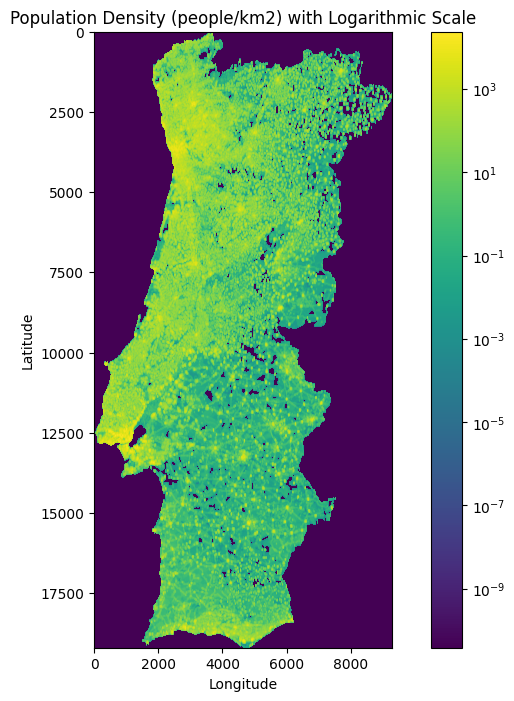

In [22]:
# Due to plot above, there are some things (namely the Azores and Madeira islands) that need to be clipped out from the raster extent

output_tiff = r"C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\Densidade_Populacional\prt_pd_2020_1km_clipped_resampled.tif"

af.reproject_clip_resample_tiff(
    input_tiff= pop_density_raster, 
    output_tiff=output_tiff, 
    aoi_shapefile=portugal_path, 
    target_srs="EPSG:32629", 
    target_res_x=30, 
    target_res_y=30, 
    resampling_method="bilinear", 
    clip=True,
    no_data=-9999
) 


# Open the raster file and clip the raster with the vector layer above with also plotting using logarithmic scale

from matplotlib.colors import LogNorm

pop_density_raster_clipped = r"C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\Densidade_Populacional\prt_pd_2020_1km_clipped_resampled.tif"

with rasterio.open(pop_density_raster_clipped) as src:
    image = src.read(1)  # Assuming land use/cover data is in the first band

    # Read the first band of the raster
    raster_data = src.read(1)
    
    # Get the No Data value from the raster metadata
    no_data_value = src.nodata

    # Replace non-positive values with a small positive value (if necessary)

    small_value = 1e-5
    raster_data[raster_data <= 0] = small_value  # or a small positive value like 1e-5

    # Plotting the raster data with a logarithmic scale
    plt.figure(figsize=(10, 8))
    plt.imshow(raster_data, cmap='viridis', norm=LogNorm(vmin=np.nanmin(raster_data), vmax=np.nanmax(raster_data)))
    plt.colorbar()
    plt.title('Population Density (people/km2) with Logarithmic Scale')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# **Land Use and Land Cover**

* https://www.dgterritorio.gov.pt/dados-abertos
* Download Carta Ocupação do Solo Simplificada (2023)

In [16]:
lulc_mapping = {
    100: "Artificializado", #Artificial land
    211: "Culturas anuais de outono/inverno", #Agriculture (Autumn / Winter)
    212: "Culturas anuais de primavera/verão", #Agriculture (Spring / Summer)
    213: "Outras áreas agrícolas", #Agriculture (Other)
    311: "Sobreiro e Azinheira", #Evergreen oaks
    312: "Eucalipto", #Eucalyptus
    313: "Outras folhosas", #Other broadleaves
    321: "Pinheiro bravo", #Maritime pine
    322: "Pinheiro manso", #Stone pine
    323: "Outras resinosas", #Other conifers
    410: "Matos", #Shrubland
    420: "Vegetação herbácea espontânea", #Natural grassland
    500: "Superfícies sem vegetação", #Bare soil
    610: "Zonas húmidas", #Wetland
    620: "Água" #Water
} 

In [24]:
input_tiff = r"C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\COSc2023_N3_v0_TM06.tif"
output_tiff = r"C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\COSc2023_N3_v0_TM06_clipped_resampled.tif"

af.reproject_clip_resample_tiff(
    input_tiff= input_tiff, 
    output_tiff=output_tiff, 
    aoi_shapefile=portugal_path, 
    target_srs="EPSG:32629", 
    target_res_x=30, 
    target_res_y=30, 
    resampling_method="bilinear", 
    clip=True,
    no_data=-9999
) 

* Convert the geotiff to a cloud optimized geotiff (COG) using GDAL
* COG has several advantages namely: (1) efficient cloud storage and access, (2) can be streamed and accessed in smaller chunks (tiles), (3) increased scalability
* I later created an AWS s3 bucket with public access in order to test it if it would load on QGIS

# Write below on the created bucket's permission tab 

* When creating a bucket uncheck all the boxes to make it public

In [5]:
""" 

{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": "*",
            "Action": "s3:GetObject",
            "Resource": "arn:aws:s3:::cog-bucket-2/*"
        }
    ]
} 

"""

' \n\n{\n    "Version": "2012-10-17",\n    "Statement": [\n        {\n            "Effect": "Allow",\n            "Principal": "*",\n            "Action": "s3:GetObject",\n            "Resource": "arn:aws:s3:::cog-bucket-2/*"\n        }\n    ]\n} \n\n'

In [ ]:
input_tiff = r"C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\COSc2023_N3_v0_TM06_clipped_resampled.tif"
output_cog = r"C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG.tif"

# Define options for COG creation
options = [
    'TILED=YES',                # Enable tiling
    'COMPRESS=DEFLATE',          # Use DEFLATE compression to reduce size
    'COPY_SRC_OVERVIEWS=YES',    # Copy existing overviews or create new ones
    'BLOCKSIZE=512',             # Tile size (adjust based on your dataset)
    'RESAMPLING=NEAREST',        # Resampling method for overviews
    'OVERVIEWS=YES'              # Build overviews (pyramids)
]

# Use gdal.Translate to convert the TIFF to COG
gdal.Translate(output_cog, input_tiff, format='COG', creationOptions=options)

print(f"Converted {input_tiff} to COG format at {output_cog}")

In [3]:
output_cog = r"C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG.tif"

# Check for COG Validation

In [5]:
info = gdal.Info(output_cog)

# Print the info and check for COG metadata
print(info)

# Optionally, look for 'LAYOUT=COG' in the info text
if "LAYOUT=COG" in info:
    print("This is a valid Cloud Optimized GeoTIFF.")
else:
    print("This is not a Cloud Optimized GeoTIFF.")

Driver: GTiff/GeoTIFF
Files: C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG.tif
Size is 9295, 19200
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 29N",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            MEMBER["World Geodetic System 1984 (G2139)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 29N",
        METHOD["Transverse Mercator",
        

In [1]:
s3_url = "https://cog-bucket-2.s3.eu-north-1.amazonaws.com/PT_COSc2023_COG.tif"


# Access COG tiff from aws s3 bucket link

In [5]:
""" # Open the raster from the S3 URL
with rasterio.open(s3_url) as src:
    # Read the image as a Dask array
    image = da.from_array(src.read(1), chunks=(10000, 10000))  # Adjust chunk size based on memory
    mask = image != 0  # Mask to exclude nodata values """

# Access COG tiff directly from local machine

In [4]:
with rasterio.open(output_cog) as src:
    # Read the image as a Dask array
    image = da.from_array(src.read(1), chunks=(10000, 10000))  # Adjust chunk size based on memory
    mask = image != 0  # Mask to exclude nodata values

    # Create a generator for shapes
    results = (
        {'properties': {'land_cover': v}, 'geometry': shape(s)}
        for i, (s, v) in enumerate(shapes(image.compute(), mask=mask.compute(), transform=src.transform))
    )

    # Create a GeoDataFrame directly from the features
    gdf = gpd.GeoDataFrame.from_features(list(results))

In [4]:
# Open the raster file
with rasterio.open(output_cog) as src:
    raster_image = src.read(1)  # Read the first band
    raster_meta = src.meta

    # Extract raster shapes and values
    results = ({'properties': {'raster_value': v}, 'geometry': s}
               for i, (s, v) in enumerate(
                   shapes(raster_image, mask=None, transform=src.transform)))

In [15]:
input_raster = r"C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG.tif"
num_parts = 8  # Number of parts to divide the raster into

In [16]:
af.subset_raster_into_parts(input_raster, num_parts)

c:\Users\fuji_\anaconda3\envs\geospatial\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Created subset: C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_1.tif
Created subset: C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_2.tif
Created subset: C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_3.tif
Created subset: C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_4.tif
Created subset: C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_5.tif
Created subset: C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_6.tif
Created subset: C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_7.tif
Created subset: C:\Users\fuji_\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_8.tif


['C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_1.tif',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_2.tif',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_3.tif',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_4.tif',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_5.tif',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_6.tif',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_7.tif',
 'C:\\Users\\fuji_\\Desktop\\Geospatial_Misc\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_8.tif']

# Batch Polygonize using .parquet 

In [4]:
raster_dir = r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC"

input_tiffs = glob.glob(os.path.join(raster_dir, '*part_*.tif'))

total_tiffs = len(input_tiffs)
print(f"Total number of TIFF files: {total_tiffs}")

input_tiffs

Total number of TIFF files: 8


['D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_1.tif',
 'D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_2.tif',
 'D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_3.tif',
 'D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_4.tif',
 'D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_5.tif',
 'D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_6.tif',
 'D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_7.tif',
 'D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_8.tif']

In [5]:
for input_tiff in input_tiffs:
    af.polygonize_raster(input_tiff, layer_name="LULC", output_format='Parquet')

Polygonization applied successfully. Output saved to D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_1.parquet
Creating output D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_1.parquet of format Parquet.
0...10...20...30...40...50...60...70...80...90...100 - done.

Polygonization applied successfully. Output saved to D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_2.parquet
Creating output D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_2.parquet of format Parquet.
0...10...20...30...40...50...60...70...80...90...100 - done.

Polygonization applied successfully. Output saved to D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_3.parquet
Creating output D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_3.parquet of format Parquet.
0...10...20...30...40...50...60...70...80...90...100 - done.

Polygonization applied successfull

# Polygonize using .parquet filetype as output

# Merge Vector Layers
* Geoparquet can't be merged like a shp, geojson or gpkg because it is an imutable file format.
* Parquet format is primarily a columnar storage format for large datasets and isn't optimized for appending or merging like traditional vector formats.

In [9]:
vector_dir = r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC"

In [10]:
af.merge_geoparquet_files(vector_dir)

Merged GeoParquet file saved as D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_merged.parquet


In [46]:
input_vectors = [glob.glob(os.path.join(vector_dir, f'*_part_*.{ext}')) for ext in ['gpkg', 'geojson', 'shp', 'parquet']]

# Flatten the list of lists into a single list
input_vectors = sum(input_vectors, [])

input_vectors

['D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_1.parquet',
 'D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_2.parquet',
 'D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_3.parquet',
 'D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_4.parquet',
 'D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_5.parquet',
 'D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_6.parquet',
 'D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_7.parquet',
 'D:\\Geospatial_Pessoal\\FFSM\\Fatores_Condicionantes\\LULC\\PT_COSc2023_COG_part_8.parquet']

In [47]:
for vector in input_vectors:
    os.remove(vector)
    print(f"Deleted {vector}")

Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_1.parquet
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_2.parquet
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_3.parquet
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_4.parquet
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_5.parquet
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_6.parquet
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_7.parquet
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_part_8.parquet


# Filter vector layers

* This could be done earlier to reduce the size of each polygonized part

In [2]:
input_merged_vector = r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_merged.parquet"
output_filtered_vector = r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_merged_filtered.parquet"
filter_values = [100,620]

In [3]:
gdf = gpd.read_parquet(input_merged_vector)

filtered_gdf = gdf[gdf['DN'].isin(filter_values)]

filtered_gdf.to_parquet(output_filtered_vector)
print(f"Filtered GeoParquet created: {output_filtered_vector}")

Filtered GeoParquet created: D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_merged_filtered.parquet


In [9]:
output_filtered_vector
output_dissolved_vector = r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_merged_filtered_dissolved.parquet"
dissolve_field ="DN"

In [10]:
af.dissolve_vector(output_filtered_vector, output_dissolved_vector, dissolve_field) 

Dissolved vector file created: D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_merged_filtered_dissolved.parquet


In [11]:
target_resolution = 30 
input_geojson = output_dissolved_vector
output_tif = r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_merged_filtered_dissolved.tiff"
no_data_value = -1
field_name = "DN"

## Distance to Water Bodies

In [12]:
af.rasterize(target_resolution,
            input_geojson,
            output_tif,
            no_data_value,
            field_name)

In [14]:
af.distance_matrix(
    input_raster_path = output_tif,
    output_raster_path = r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_merged_filtered_dissolved_idw_water.tiff", 
    target_value = 620
)

## Distance to Residential Areas

In [16]:
af.distance_matrix(
    input_raster_path = output_tif, 
    output_raster_path = r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\LULC\PT_COSc2023_COG_merged_filtered_dissolved_idw_residential.tiff", 
    target_value=100
)

# Windspeed (mean)

* Globalwindatlas tiff used

## Add arguments for clipping, reprojecting, resampling and setting no data value

In [23]:
input_tiff = fr"{user_dir}\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\Windspeed\PRT_wind-speed_100m.tif"
aoi_shapefile = vector_path
target_res_x = 30
target_res_y = 30
resampling_method="bilinear"
output_tiff = fr"{user_dir}\Desktop\Geospatial_Misc\FFSM\Fatores_Condicionantes\Windspeed\PRT_wind-speed_100m_clipped_resampled.tif"
target_srs = "EPSG:32629"
no_data=-9999
aoi_shapefile = fr"{user_dir}\Desktop\Geospatial_Misc\Portugal_Boundaries\PORTUGAL_AOI\Portugal_AOI_wgs84.geojson"

In [24]:
af.reproject_clip_resample_tiff(input_tiff=input_tiff, 
                                 output_tiff=output_tiff, 
                                 aoi_shapefile=aoi_shapefile ,
                                 target_srs=target_srs, 
                                 target_res_x=target_res_x, 
                                 target_res_y=target_res_y, 
                                 resampling_method=resampling_method, 
                                 clip=True, 
                                 clip_by_extent=False, 
                                 no_data=no_data)

# Elevation

In [6]:
# Your rectangle WKT string, use https://geojson.io/ and save as WKT (open in a text editor to copy the coordinates)

#WKT
wkt_string = "POLYGON ((-9.691880464871304 42.2103384624466, -9.691880464871304 36.708029231300756, -6.1259015927917915 36.708029231300756, -6.1259015927917915 42.2103384624466, -9.691880464871304 42.2103384624466))"

# Manual conversion from WKT to a list of coordinates for Earth Engine
coordinates_str = wkt_string.strip('POLYGON ((').strip('))').split(', ')
coordinates = [[float(coord) for coord in point.split(' ')] for point in coordinates_str]

ee_geometry = ee.Geometry.Polygon([coordinates])

location = ee_geometry.coordinates().getInfo()[::-1]
location

[[[-9.691880464871304, 36.708029231300756],
  [-6.1259015927917915, 36.708029231300756],
  [-6.1259015927917915, 42.2103384624466],
  [-9.691880464871304, 42.2103384624466],
  [-9.691880464871304, 36.708029231300756]]]

In [7]:
dem = ee.ImageCollection("projects/sat-io/open-datasets/FABDEM").mosaic()

# Mask values below 0 meters
dem_land = dem.updateMask(dem.gte(0))

band_names = dem_land.bandNames().getInfo()
print('Band names:', band_names)

Band names: ['b1']


## Statistics

In [5]:
# Assuming there's only one band, typically this is the case with DEMs
band_name = band_names[0]

# Find minimum and maximum values
stats = dem_land.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=geometries,
    scale = 30,
    maxPixels=1e13
)

# Print the stats dictionary to inspect the keys
print(stats.getInfo())

# Fetch the results using the correct key names
min_val_key = f'{band_name}_min'
max_val_key = f'{band_name}_max'

min_val = stats.getInfo()[min_val_key]
max_val = stats.getInfo()[max_val_key]

print('Min value:', min_val)
print('Max value:', max_val)

EEException: Invalid GeoJSON geometry.

In [5]:
# Parameters for exporting using geemap
scale = 30  # Resolution in meters
filename = r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem.tif" 
# Set export region from WKT
region = ee_geometry  

## Export DEM locally

In [6]:
def split_region(geometry, n):
    tiles = []
    bounds = geometry.bounds().getInfo()["coordinates"][0]
    x_min, y_min = bounds[0]
    x_max, y_max = bounds[2]
    width = x_max - x_min
    height = y_max - y_min
    tile_width = width / n
    tile_height = height / n
    for i in range(n):
        for j in range(n):
            x1 = x_min + i * tile_width
            y1 = y_min + j * tile_height
            x2 = x1 + tile_width
            y2 = y1 + tile_height
            tiles.append(ee.Geometry.Rectangle([x1, y1, x2, y2]))
    return tiles


In [7]:
# Split the region into 4x4 tiles

n_tiles = 6
tiles = split_region(ee_geometry, n_tiles)

In [8]:
for idx, tile in enumerate(tiles):
    filename = fr"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_{idx}.tif" 
    geemap.ee_export_image(
        dem_land,
        filename=filename,
        scale=30,
        region=tile,
        file_per_band=False,
        crs="EPSG:32629"
    )
    print(f'Tile {idx} has been successfully exported as {filename}')

Generating URL ...
Please wait ...
Data downloaded to D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_0.tif
Tile 0 has been successfully exported as D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_0.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_1.tif
Tile 1 has been successfully exported as D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_1.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_2.tif
Tile 2 has been successfully exported as D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_2.tif
Generating URL ...
Please wait ...
Data downloaded to D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_3.tif
Tile 3 has been successfully exported as D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Ele

In [9]:
af.merge_tiffs(input_dir=r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation",
               output_tif = fr"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_merged.tif")

Found 36 TIFF files to merge.


c:\Users\fuji_\anaconda3\envs\geospatial\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Merge successful. Output saved to D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_merged.tif


## Tile Deletion

In [10]:
input_dir = r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation"

input_rasters = [glob.glob(os.path.join(input_dir, f'*_tile_*.{ext}')) for ext in ['tif']]

# Flatten the list of lists into a single list
input_rasters = sum(input_rasters, [])

for raster in input_rasters:
    os.remove(raster)
    print(f"Deleted {raster}")

Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_0.tif
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_1.tif
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_10.tif
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_11.tif
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_12.tif
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_13.tif
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_14.tif
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_15.tif
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_16.tif
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_17.tif
Deleted D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_tile_18.tif
Deleted D:\G

## Clipping

In [2]:
data = rioxarray.open_rasterio(r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_merged.tif")

bounds = gpd.read_file(r"D:\Geospatial_Pessoal\Portugal_Boundaries\pt_dissolved_geojson_3763.geojson")

In [4]:
if bounds.geometry.type.isin(['MultiPolygon']).any():
    bounds = bounds.explode(index_parts=False)
    print("There are multipolygons in this file and they have been exploded into individual polygons.")
else:
    print("No multipolygons found in this file.")

clipped_fabdem = data.rio.clip(bounds.geometry.tolist(), bounds.crs)

clipped_fabdem.rio.to_raster(r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_merged_clipped.tif")

No multipolygons found in this file.


# Slope Angle

In [3]:
slope_path = af.calculate_slope(
    input_dem = r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Elevation\PT_fabdem_merged_clipped.tif",
    output_slope = r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Slope\PT_fabdem_merged_clipped_slope.tif"
)

# Aspect

In [5]:
aspect_path = af.calculate_aspect(
    input_dem = slope_path["input_dem"],
    output_aspect = r"D:\Geospatial_Pessoal\FFSM\Fatores_Condicionantes\Aspect\PT_fabdem_merged_clipped_aspect.tif"
)